In [1]:
import os
import json
import hashlib
import numpy as np
from qcelemental import constants
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
from functions import zetacolors, extrapolations, getFuncPars, prettifyBasis, prettifyFunc

In [2]:
with open(os.path.join("..", "external", "ASCDB.csv"), "r") as infile:
    reflines = infile.readlines()

dbpath = os.path.join("..", "data", "ASCDB")

In [3]:
refdata = {}
for line in reflines:
    items = line.strip().split(",")
    nr = int((len(items) - 2) / 2)
    refdata[items[0]] = {'dE': float(items[1]), "rxn": {}}
    for i in range(2, 2+nr):
        if items[i] not in refdata[items[0]]["rxn"]:
            refdata[items[0]]["rxn"][items[i]] = int(items[i + nr])
        else:
            refdata[items[0]]["rxn"][items[i]] += int(items[i + nr])

In [4]:
functionals = ["pbe-d3bj", "pbe0-d3bj", "pbe0-dh-d3bj"]
bases = [
    "cc-pvdz", "cc-pvtz", "cc-pvqz", 
    "aug-cc-pvdz", "aug-cc-pvtz", "aug-cc-pvqz",
    "def2-svp", "def2-tzvp", "def2-tzvpp", "def2-qzvp", "def2-qzvpp",
    "def2-svpd", "def2-tzvpd", "def2-tzvppd", "def2-qzvpd", "def2-qzvppd",
    "cc-pwcvdz", "cc-pwcvtz", "cc-pwcvqz",
    "aug-cc-pwcvdz", "aug-cc-pwcvtz", "aug-cc-pwcvqz",
    "pcseg-1", "pcseg-2", "pcseg-3",
    "aug-pcseg-1", "aug-pcseg-2", "aug-pcseg-3",
]
bfamily = [
    ["cc-pvdz", "cc-pvtz", "cc-pvqz"],
    ["aug-cc-pvdz", "aug-cc-pvtz", "aug-cc-pvqz"],
    ["def2-svp", "def2-tzvp", "def2-qzvp"],
    ["def2-svpd", "def2-tzvpd", "def2-qzvpd"],
    ["cc-pwcvdz", "cc-pwcvtz", "cc-pwcvqz"],
    ["aug-cc-pwcvdz", "aug-cc-pwcvtz", "aug-cc-pwcvqz"],
    ["pcseg-1","pcseg-2","pcseg-3"],
    ["aug-pcseg-1","aug-pcseg-2","aug-pcseg-3"],
]
xtplbases = [
    ["cc-pv[dt]z", "cc-pv[tq]z"],
    ["aug-cc-pv[dt]z", "aug-cc-pv[tq]z"],
    ["def2-[st]zvp", "def2-[tq]zvp"],
    ["def2-[st]zvpd", "def2-[tq]zvpd"],
    ["cc-pwcv[dt]z", "cc-pwcv[tq]z"],
    ["aug-cc-pwcv[dt]z", "aug-cc-pwcv[tq]z"],
    ["pcseg-[12]","pcseg-[23]"],
    ["aug-pcseg-[12]","aug-pcseg-[23]"],
]
bases = np.array(bfamily).flatten()

In [5]:
def getFuncPars(functional):
    if functional == "pbe-d3bj":
        return (0.0, 0.0)
    elif functional == "pbe0-d3bj":
        return (0.25, 0.0)
    elif functional == "pbe0-dh-d3bj":
        return (0.5, 0.125)
    else:
        raise ValueError

In [6]:
psi4data = {}
for reaction, reacpars in refdata.items():
    psi4data[reaction] = {}
    for species, stoich in reacpars["rxn"].items():
        psi4data[reaction][species] = {}
        for func in functionals:
            psi4data[reaction][species][func] = {}
            for basis in bases:
                casename = f"{func} {basis} {species}"
                casehash = hashlib.sha256(casename.encode("utf-8")).hexdigest()[:10]
                if os.path.exists(os.path.join(dbpath, f"{casehash}.json")):
                    with open(os.path.join(dbpath, f"{casehash}.json"), "r") as jsfile:
                        data = json.load(jsfile)
                    if data["success"]:
                        psi4data[reaction][species][func][basis] = {
                            "tot": data["return_result"],
                            "fctl": data["extras"]["qcvars"]["DFT FUNCTIONAL TOTAL ENERGY"],
                            "dh": data["extras"]["qcvars"].get("DOUBLE-HYBRID CORRECTION ENERGY", 0),
                            "disp": data["extras"]["qcvars"].get("DISPERSION CORRECTION ENERGY", 0),
                            "nl": data["extras"]["qcvars"].get("DFT VV10 ENERGY", 0)
                        }
            for xtpl in extrapolations:
                if len(set(psi4data[reaction][species][func].keys()).intersection(extrapolations[xtpl]["comps"])) != 2:
                    continue
                ax, ac = getFuncPars(func)
                Zlo = extrapolations[xtpl]["zetas"][0]
                Zhi = extrapolations[xtpl]["zetas"][1]
                α = extrapolations[xtpl]["α0"] + ax * extrapolations[xtpl]["αx"] + ac * extrapolations[xtpl]["αc"]
                Elo = psi4data[reaction][species][func][extrapolations[xtpl]["comps"][0]]["fctl"] - psi4data[reaction][species][func][extrapolations[xtpl]["comps"][0]]["nl"]
                Ehi = psi4data[reaction][species][func][extrapolations[xtpl]["comps"][1]]["fctl"] - psi4data[reaction][species][func][extrapolations[xtpl]["comps"][1]]["nl"]
                b_div = 1 / (np.exp(-1 * α * np.sqrt(Zhi)) - np.exp(-1 * α * np.sqrt(Zlo)))
                b_mul = np.exp(-1 * α * np.sqrt(Zhi))
                b = (Ehi - Elo) * b_div
                Efctl = Ehi - b * b_mul
                α = extrapolations[xtpl]["αdh"]
                Elo = psi4data[reaction][species][func][extrapolations[xtpl]["comps"][0]]["dh"]
                Ehi = psi4data[reaction][species][func][extrapolations[xtpl]["comps"][1]]["dh"]
                b_div = 1 / (Zhi**(-1 * α) - Zlo**(-1 * α))
                b_mul = Zhi**(-1 * α)
                b = (Ehi - Elo) * b_div
                Edh = Ehi - b * b_mul
                Edisp = psi4data[reaction][species][func][extrapolations[xtpl]["comps"][1]]["disp"]
                Enl = psi4data[reaction][species][func][extrapolations[xtpl]["comps"][1]]["nl"]
                psi4data[reaction][species][func][xtpl] = {"tot": Efctl + Edh + Edisp + Enl}
                    

In [7]:
ascdb = {}
for func in functionals:
    ascdb[func] = {}
    for basis in bases:
        ascdb[func][basis] = {"nc": [], "th": [], "nl": [], "ub": []}
    for basis in extrapolations:
        ascdb[func][basis] = {"nc": [], "th": [], "nl": [], "ub": []}

In [8]:
def dictmerge(d):
    return [v for ks, vs in d.items() for v in vs]

for func in ascdb.keys():
    for basis in ascdb[func].keys():
        for reaction, reacpars in refdata.items():
            if reaction.startswith("NC"):
                tag = "nc"
            elif reaction.startswith("AR") or reaction.startswith("BH"):
                tag = "th"
            elif reaction.startswith("NL"):
                tag = "nl"
            elif reaction.startswith("MB") or reaction.startswith("AE"):
                tag = "ub"
            Eref = reacpars["dE"]
            Ecalc = 0
            success = True
            for species, stoich in reacpars["rxn"].items():
                if basis in psi4data[reaction][species][func]:
                    Ecalc += stoich * psi4data[reaction][species][func][basis]["tot"]
                else:
                    success = False
            if success:
                dE = abs(Eref - Ecalc) * constants.hartree2kJmol
                if reaction.startswith("AE18pE"):
                    nel = int(reaction.split("_")[1])
                    dE = dE / nel
                ascdb[func][basis][tag].append(dE)
                #if func == "pbe-d3bj" and basis == "aug-cc-pwcvtz" and dE > 100:
                #    print(dE, refdata[reaction])
            else:
                pass
                #print(reaction, basis, func)
        allres = dictmerge(ascdb[func][basis])
        if len(allres) < 200 and len(allres) > 0:
            print(f"{func + '/' + basis:30s} {np.mean(allres):10.1f}, {len(allres):4d} "
                  f"{'x' if len(allres) == 200 else ' '} {max(allres):10.1f}")

pbe-d3bj/cc-pwcvdz                   78.2,  184        745.5
pbe-d3bj/cc-pwcvtz                   66.2,  193        625.8
pbe-d3bj/cc-pwcvqz                   60.6,  194        626.0
pbe-d3bj/aug-cc-pwcvdz               57.2,  184        657.7
pbe-d3bj/aug-cc-pwcvtz               56.4,  193        589.0
pbe-d3bj/aug-cc-pwcvqz               56.8,  191        608.9
pbe-d3bj/pcseg-1                     70.0,  198        748.5
pbe-d3bj/pcseg-2                     58.3,  198        603.6
pbe-d3bj/pcseg-3                     55.7,  198        602.6
pbe-d3bj/aug-pcseg-1                 60.2,  198        666.1
pbe-d3bj/aug-pcseg-2                 56.4,  198        605.6
pbe-d3bj/aug-pcseg-3                 55.6,  197        602.8
pbe-d3bj/cc-pwcv[dt]z                63.5,  184        648.4
pbe-d3bj/cc-pwcv[tq]z                58.4,  193        626.1
pbe-d3bj/aug-cc-pwcv[dt]z            56.3,  184        623.1
pbe-d3bj/aug-cc-pwcv[tq]z            57.1,  190        617.5
pbe-d3bj/pcseg-[12]     

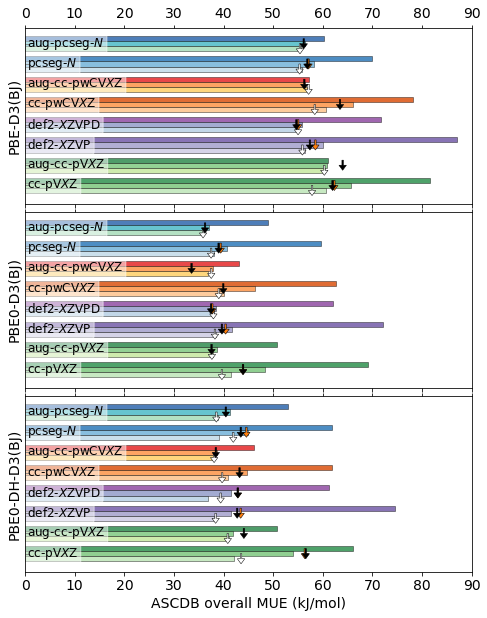

In [9]:
fig = plt.figure(figsize=(8,10))
grid = plt.GridSpec(3, 1, wspace=0.1, hspace=0.05, figure=fig)
ax = []

ax.append(plt.subplot(grid[0:1, :]))
ax.append(plt.subplot(grid[1:2, :]))
ax.append(plt.subplot(grid[2:3, :]))

h = 0.25
w = 0.3

ai = 0
for func in functionals:
    yticks = []
    for y in range(len(bfamily)):
        yticks.append(f'{prettifyBasis(bfamily[y][-1])}')
        yoff = h
        for bi in range(len(bfamily[y])):
            basis = bfamily[y][bi]
            z = bi+2
            ax[ai].barh(y + yoff , np.mean(dictmerge(ascdb[func][basis])), color=zetacolors[basis], 
                        edgecolor="k", linewidth=0.5, height=h, zorder=1, alpha=0.8)
            yoff -= h
    for y in range(len(xtplbases)):
        for bi in range(len(xtplbases[y])):
            basis = xtplbases[y][bi]
            ax[ai].arrow(np.mean(dictmerge(ascdb[func][basis])), y+h if bi == 0 else y, 
                        0, -2*h, width = w, head_width=w*5, head_length=h, length_includes_head = True,
                        facecolor = "k" if bi == 0 else "w", edgecolor="k", linewidth=0.5, zorder = 3 if bi == 0 else 2)
    for basis, offset in [["cc-pv[dt]z-v1", 0], ["def2-[st]zvp-v1", 2], ["def2-[st]zvpd-v1", 3], ["pcseg-[12]-v1", 6]]:
        ax[ai].arrow(np.mean(dictmerge(ascdb[func][basis])), offset+h, 0, -2*h,
                    width = w, head_width=w*5, head_length=h, length_includes_head = True,
                    facecolor = "C1", edgecolor="k", linewidth=0.5, zorder = 2)      
    ax[ai].set_ylabel(prettifyFunc(func))
    ax[ai].set_xlim(left=0, right=90)
    ax[ai].tick_params(axis="y",direction="in", pad=-2)
    ax[ai].set_yticks(range(len(yticks)))
    ax[ai].set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
    bbox = dict(boxstyle="round", ec="white", fc="white", alpha=0.5, pad=0.2)
    plt.setp(ax[ai].get_yticklabels(), bbox=bbox)
    ax[ai].tick_params(top=True, bottom=True, labeltop=False, labelbottom=False)
    if ai == 0:
        ax[ai].tick_params(labeltop=True)
    elif ai == 2:
        ax[ai].tick_params(labelbottom=True)
        ax[ai].set_xlabel("ASCDB overall MUE (kJ/mol)")
    ai += 1
plt.show()
fig.savefig(os.path.join("..","output","fig_ascdb_all.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")

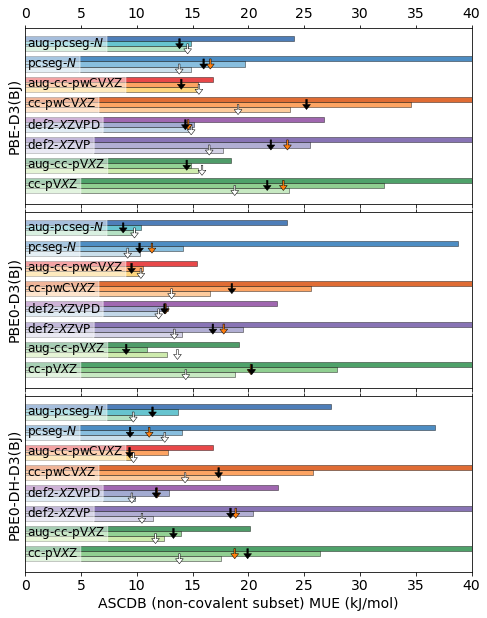

In [10]:
fig = plt.figure(figsize=(8,10))
grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.05, figure=fig)
ax = []
tag = "nc"
ax.append(plt.subplot(grid[0:1, :]))
ax.append(plt.subplot(grid[1:2, :]))
ax.append(plt.subplot(grid[2:3, :]))

h = 0.25
w = 0.14

ai = 0
for func in functionals:
    yticks = []
    for y in range(len(bfamily)):
        yticks.append(f'{prettifyBasis(bfamily[y][-1])}')
        yoff = h
        for bi in range(len(bfamily[y])):
            basis = bfamily[y][bi]
            z = bi+2
            ax[ai].barh(y + yoff , np.mean(ascdb[func][basis][tag]), color=zetacolors[basis], 
                        edgecolor="k", linewidth=0.5, height=h, zorder=1, alpha=0.8)
            yoff -= h
    for y in range(len(xtplbases)):
        for bi in range(len(xtplbases[y])):
            basis = xtplbases[y][bi]
            ax[ai].arrow(np.mean(ascdb[func][basis][tag]), y+h if bi == 0 else y, 
                        0, -2*h, width = w, head_width=w*5, head_length=h, length_includes_head = True,
                        facecolor = "k" if bi == 0 else "w", edgecolor="k", linewidth=0.5, zorder = 3 if bi == 0 else 2)
    for basis, offset in [["cc-pv[dt]z-v1", 0], ["def2-[st]zvp-v1", 2], ["def2-[st]zvpd-v1", 3], ["pcseg-[12]-v1", 6]]:
        ax[ai].arrow(np.mean(ascdb[func][basis][tag]), offset+h, 0, -2*h,
                    width = w, head_width=w*5, head_length=h, length_includes_head = True,
                    facecolor = "C1", edgecolor="k", linewidth=0.5, zorder = 2)
    ax[ai].set_ylabel(prettifyFunc(func))
    ax[ai].set_xlim(left=0, right=40)
    ax[ai].tick_params(axis="y",direction="in", pad=-2)
    ax[ai].set_yticks(range(len(yticks)))
    ax[ai].set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
    bbox = dict(boxstyle="round", ec="white", fc="white", alpha=0.5, pad=0.2)
    plt.setp(ax[ai].get_yticklabels(), bbox=bbox)
    ax[ai].tick_params(top=True, bottom=True, labeltop=False, labelbottom=False)
    if ai == 0:
        ax[ai].tick_params(labeltop=True)
    elif ai == 2:
        ax[ai].tick_params(labelbottom=True)
        ax[ai].set_xlabel("ASCDB (non-covalent subset) MUE (kJ/mol)")
    ai += 1
plt.show()
fig.savefig(os.path.join("..","output","fig_ascdb_nc.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")

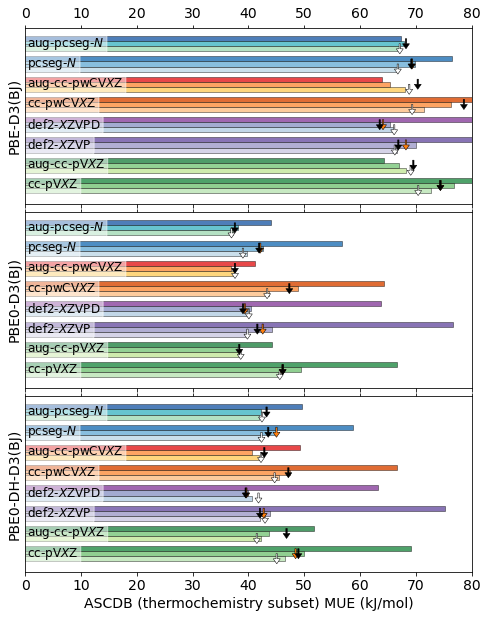

In [11]:
fig = plt.figure(figsize=(8,10))
grid = plt.GridSpec(3, 1, wspace=0.1, hspace=0.05, figure=fig)
ax = []
tag = "th"
ax.append(plt.subplot(grid[0:1, :]))
ax.append(plt.subplot(grid[1:2, :]))
ax.append(plt.subplot(grid[2:3, :]))
h = 0.25
w = 0.25

ai = 0
for func in functionals:
    yticks = []
    for y in range(len(bfamily)):
        yticks.append(f'{prettifyBasis(bfamily[y][-1])}')
        yoff = h
        for bi in range(len(bfamily[y])):
            basis = bfamily[y][bi]
            z = bi+2
            ax[ai].barh(y + yoff , np.mean(ascdb[func][basis][tag]), color=zetacolors[basis], 
                        edgecolor="k", linewidth=0.5, height=h, zorder=1, alpha=0.8)
            yoff -= h
    for y in range(len(xtplbases)):
        for bi in range(len(xtplbases[y])):
            basis = xtplbases[y][bi]
            ax[ai].arrow(np.mean(ascdb[func][basis][tag]), y+h if bi == 0 else y, 
                        0, -2*h, width = w, head_width=w*5, head_length=h, length_includes_head = True,
                        facecolor = "k" if bi == 0 else "w", edgecolor="k", linewidth=0.5, zorder = 3 if bi == 0 else 2)
    for basis, offset in [["cc-pv[dt]z-v1", 0], ["def2-[st]zvp-v1", 2], ["def2-[st]zvpd-v1", 3], ["pcseg-[12]-v1", 6]]:
        ax[ai].arrow(np.mean(ascdb[func][basis][tag]), offset+h, 0, -2*h,
                    width = w, head_width=w*5, head_length=h, length_includes_head = True,
                    facecolor = "C1", edgecolor="k", linewidth=0.5, zorder = 2)
    ax[ai].set_ylabel(prettifyFunc(func))
    ax[ai].set_xlim(left=0, right=80)
    ax[ai].tick_params(axis="y",direction="in", pad=-2)
    ax[ai].set_yticks(range(len(yticks)))
    ax[ai].set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
    bbox = dict(boxstyle="round", ec="white", fc="white", alpha=0.5, pad=0.2)
    plt.setp(ax[ai].get_yticklabels(), bbox=bbox)
    ax[ai].tick_params(top=True, bottom=True, labeltop=False, labelbottom=False)
    if ai == 0:
        ax[ai].tick_params(labeltop=True)
    elif ai == 2:
        ax[ai].tick_params(labelbottom=True)
        ax[ai].set_xlabel("ASCDB (thermochemistry subset) MUE (kJ/mol)")
    ai += 1
plt.show()
fig.savefig(os.path.join("..","output","fig_ascdb_th.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")

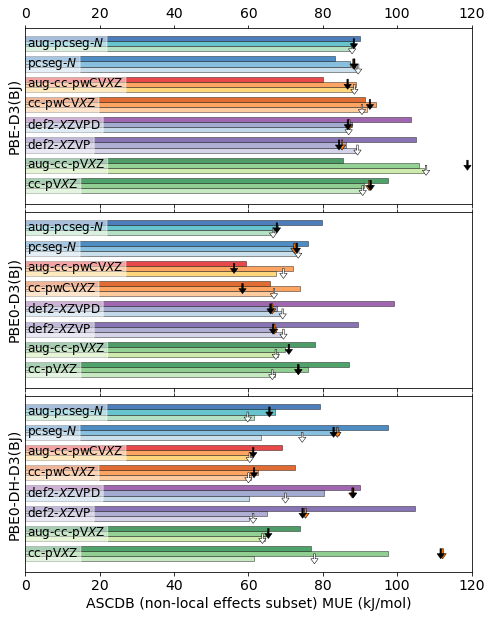

In [12]:
fig = plt.figure(figsize=(8,10))
grid = plt.GridSpec(3, 1, wspace=0.1, hspace=0.05, figure=fig)
ax = []
tag = "nl"
ax.append(plt.subplot(grid[0:1, :]))
ax.append(plt.subplot(grid[1:2, :]))
ax.append(plt.subplot(grid[2:3, :]))
h = 0.25
w = 0.4

ai = 0
for func in functionals:
    yticks = []
    for y in range(len(bfamily)):
        yticks.append(f'{prettifyBasis(bfamily[y][-1])}')
        yoff = h
        for bi in range(len(bfamily[y])):
            basis = bfamily[y][bi]
            z = bi+2
            ax[ai].barh(y + yoff , np.mean(ascdb[func][basis][tag]), color=zetacolors[basis], 
                        edgecolor="k", linewidth=0.5, height=h, zorder=1, alpha=0.8)
            yoff -= h
    for y in range(len(xtplbases)):
        for bi in range(len(xtplbases[y])):
            basis = xtplbases[y][bi]
            ax[ai].arrow(np.mean(ascdb[func][basis][tag]), y+h if bi == 0 else y, 
                        0, -2*h, width = w, head_width=w*5, head_length=h, length_includes_head = True,
                        facecolor = "k" if bi == 0 else "w", edgecolor="k", linewidth=0.5, zorder = 3 if bi == 0 else 2)
    for basis, offset in [["cc-pv[dt]z-v1", 0], ["def2-[st]zvp-v1", 2], ["def2-[st]zvpd-v1", 3], ["pcseg-[12]-v1", 6]]:
        ax[ai].arrow(np.mean(ascdb[func][basis][tag]), offset+h, 0, -2*h,
                    width = w, head_width=w*5, head_length=h, length_includes_head = True,
                    facecolor = "C1", edgecolor="k", linewidth=0.5, zorder = 2)
    ax[ai].set_ylabel(prettifyFunc(func))
    ax[ai].set_xlim(left=0, right=120)
    ax[ai].tick_params(axis="y",direction="in", pad=-2)
    ax[ai].set_yticks(range(len(yticks)))
    ax[ai].set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
    bbox = dict(boxstyle="round", ec="white", fc="white", alpha=0.5, pad=0.2)
    plt.setp(ax[ai].get_yticklabels(), bbox=bbox)
    ax[ai].tick_params(top=True, bottom=True, labeltop=False, labelbottom=False)
    if ai == 0:
        ax[ai].tick_params(labeltop=True)
    elif ai == 2:
        ax[ai].tick_params(labelbottom=True)
        ax[ai].set_xlabel("ASCDB (non-local effects subset) MUE (kJ/mol)")
    ai += 1
plt.show()
fig.savefig(os.path.join("..","output","fig_ascdb_nl.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")

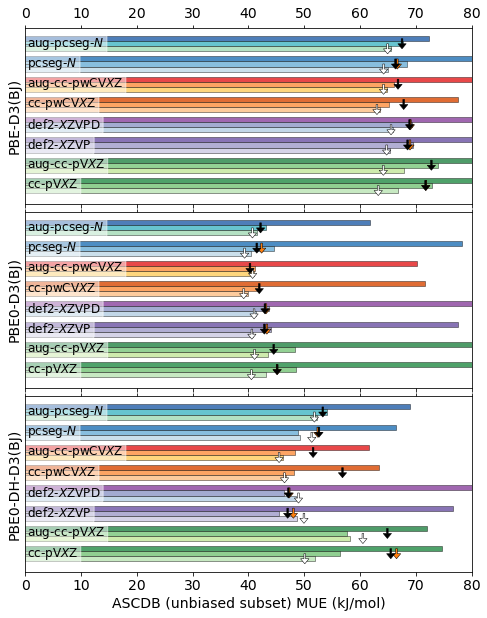

In [13]:
fig = plt.figure(figsize=(8,10))
grid = plt.GridSpec(3, 1, wspace=0.1, hspace=0.05, figure=fig)
ax = []
tag = "ub"
ax.append(plt.subplot(grid[0:1, :]))
ax.append(plt.subplot(grid[1:2, :]))
ax.append(plt.subplot(grid[2:3, :]))
h = 0.25
w = 0.3
ai = 0
for func in functionals:
    yticks = []
    for y in range(len(bfamily)):
        yticks.append(f'{prettifyBasis(bfamily[y][-1])}')
        yoff = h
        for bi in range(len(bfamily[y])):
            basis = bfamily[y][bi]
            z = bi+2
            ax[ai].barh(y + yoff , np.mean(ascdb[func][basis][tag]), color=zetacolors[basis], 
                        edgecolor="k", linewidth=0.5, height=h, zorder=1, alpha=0.8)
            yoff -= h
    for y in range(len(xtplbases)):
        for bi in range(len(xtplbases[y])):
            basis = xtplbases[y][bi]
            ax[ai].arrow(np.mean(ascdb[func][basis][tag]), y+h if bi == 0 else y, 
                        0, -2*h, width = w, head_width=w*5, head_length=h, length_includes_head = True,
                        facecolor = "k" if bi == 0 else "w", edgecolor="k", linewidth=0.5, zorder = 3 if bi == 0 else 2)
    for basis, offset in [["cc-pv[dt]z-v1", 0], ["def2-[st]zvp-v1", 2], ["def2-[st]zvpd-v1", 3], ["pcseg-[12]-v1", 6]]:
        ax[ai].arrow(np.mean(ascdb[func][basis][tag]), offset+h, 0, -2*h,
                    width = w, head_width=w*5, head_length=h, length_includes_head = True,
                    facecolor = "C1", edgecolor="k", linewidth=0.5, zorder = 2)
    ax[ai].set_ylabel(prettifyFunc(func))
    ax[ai].set_xlim(left=0, right=80)
    ax[ai].tick_params(axis="y",direction="in", pad=-2)
    ax[ai].set_yticks(range(len(yticks)))
    ax[ai].set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
    bbox = dict(boxstyle="round", ec="white", fc="white", alpha=0.5, pad=0.2)
    plt.setp(ax[ai].get_yticklabels(), bbox=bbox)
    ax[ai].tick_params(top=True, bottom=True, labeltop=False, labelbottom=False)
    if ai == 0:
        ax[ai].tick_params(labeltop=True)
    elif ai == 2:
        ax[ai].tick_params(labelbottom=True)
        ax[ai].set_xlabel("ASCDB (unbiased subset) MUE (kJ/mol)")
    ai += 1
plt.show()
fig.savefig(os.path.join("..","output","fig_ascdb_ub.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")